# MCMC Fitting the emission profile to an emission spectrum  

This example conducts HMC-NUTS fitting to a mock absorption line. We use Schwarzchild equation of the absorption model based on Tepper 
approximation of Voigt profile, lpf.FAbsVTc in exojax.lpf (line profile functions) module. 

HMC-NUTS: Hamiltonian Monte Carlo No-U-Turn Sample using numpyro

In [1]:
# importing lpf modile in exojax.spec
%load_ext autoreload
%autoreload 2
from exojax.spec import lpf,planck
from exojax.spec import rtransfer as rt

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import arviz

import numpy as np
import jax.numpy as jnp
from jax import random
from jax.lax import map, scan
from jax import vmap
import numpyro.distributions as dist
import numpyro
from numpyro.infer import MCMC, NUTS
from numpyro.infer import Predictive
from numpyro.diagnostics import hpdi

plt.style.use('bmh')
numpyro.set_platform("cpu")
#numpyro.set_platform("gpu")

/home/kawahara/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
NP=17
Parr, k=rt.const_p_layer(NP=NP)
Tarr = 1000.*(Parr/Parr[0])**-0.1
#for i in range(0,NP-1):
#    print(i, Parr[i]*k, Parr[i+1]-Parr[i],Parr[i])


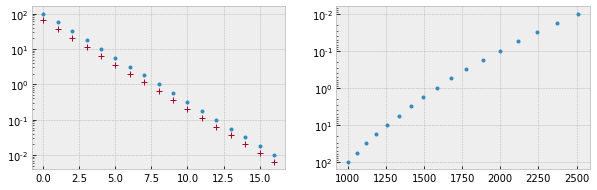

In [4]:
fig=plt.figure(figsize=(10,3))
ax=fig.add_subplot(121)
ax.plot(Parr,".")
ax.plot(Parr/(k+1),"+")
plt.yscale("log")
ax=fig.add_subplot(122)
ax.plot(Tarr,Parr,".")
#plt.xscale("log")
plt.yscale("log")
plt.gca().invert_yaxis()

In [5]:
N=50
nuarr=jnp.linspace(-10,10,N)
def add_layer(carry,x):
    """
    Params:
      carry: F[i], P[i]
      x: free parameters, T
      
    Returns:
      FP: F[i+1], P[i+1]=k*P[i]
      dtaui: dtau of this layer
    """
    F,Pi,nu0,sigmaD,gammaL = carry
    Ti = x
    numic=0.5
    #dP = k*Pi
    gi = planck.nB(Ti,numic)
    #dtaui = 1.e-1*lpf.VoigtTc(nuarr-nu0,sigmaD,gammaL)*(1.0-k)*Pi
    dtaui = 1.e-1*lpf.VoigtHjert(nuarr-nu0,sigmaD,gammaL)*(1.0-k)*Pi
    Trans=(1.0-dtaui)*jnp.exp(-dtaui)
    F = F*Trans + gi*(1.0-Trans)
    carry=[F,k*Pi,nu0,sigmaD,gammaL] #carryover 
    return carry,dtaui

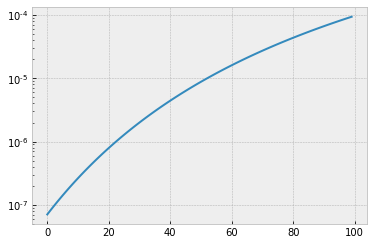

In [6]:
plt.plot(planck.nB(jnp.linspace(500,1000,100),0.5))
plt.yscale("log")

In [7]:
Parr[0]*k,Parr[1],Parr[0]-Parr[1],(1.0-k)*Parr[0]

(DeviceArray(56.234135, dtype=float32),
 DeviceArray(56.23413, dtype=float32),
 DeviceArray(43.76587, dtype=float32),
 DeviceArray(43.765865, dtype=float32))

In [8]:
1/(k+1) - 1

-0.3599350001971149

In [9]:

def g(xs):
    """
    Params: 
      xs: free parameters
    """
    Tarr=xs
    numic=0.5
    F0=jnp.ones(len(nuarr))*planck.nB(Tarr[0],numic)
    #F0=0.0
    init=[F0,Parr[0],0.7,1.0,0.5]
    FP,null=scan(add_layer,init,Tarr,NP)
    return FP[0]*3.e4

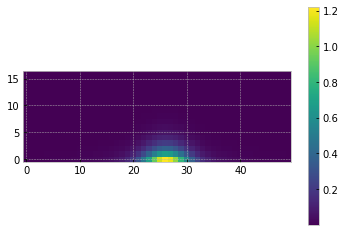

In [10]:
F0=jnp.zeros(len(nuarr))
init=[F0,Parr[0],0.7,1.0,0.5]
FP,tauarr=scan(add_layer,init,Tarr.T,NP)
c=plt.imshow(tauarr)
plt.colorbar(c)
plt.gca().invert_yaxis()

In [94]:
#memo
a=jnp.array([[1,2,3],[1,2,3]])
b=jnp.array([[1,2,5],[1,2,4]])
jnp.sum(a*b,axis=1)
#a=jnp.array([1,2,3])
#a[::-1]

DeviceArray([3, 2, 1], dtype=int32)

In [177]:
NP=30
Parr, k=rt.const_p_layer(NP=NP)
dParr = (1.0-k)*Parr
Parr=Parr[::-1] ### define from upper layer
dParr=dParr[::-1]
Tarr = 1000.*(Parr/Parr[0])**-0.1

In [178]:
numic=0.5
gi = planck.nB(Tarr,numic)
dParr = (1.0-k)*Parr
nu0=0.7
sigmaD=1.0
gammaL=0.5
xsv=1.e-1*lpf.VoigtHjert(nuarr-nu0,sigmaD,gammaL)
dtauM=dParr[None,:]*xsv[:,None]
TransM=(1.0-dtauM)*jnp.exp(-dtauM)
#Q0=jnp.ones(len(nuarr))*planck.nB(Tarr[0],numic)
Qv=(1-TransM)*gi
F=(jnp.sum(Qv*jnp.cumprod(TransM,axis=1),axis=1))
F=F*3.e7
#np.shape(Qv),np.shape(jnp.cumprod(TransM,axis=1))

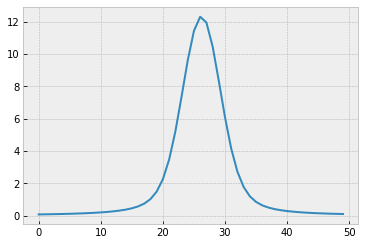

In [179]:
plt.plot(F)

In [180]:
a=jnp.array([1.,2.,3.,4.])
from jax import grad
jnp.cumprod(a)

def f(x):
    return jnp.sum(jnp.cumprod(x))
f(a)
g=grad(f)
g(a)

DeviceArray([33., 16., 10.,  6.], dtype=float32)

In [181]:
from jax import grad

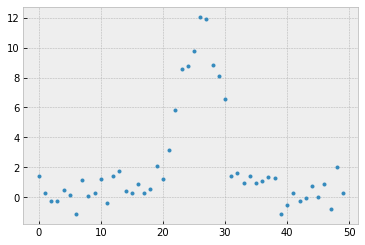

In [182]:
sigin=0.8
data=F+np.random.normal(0,sigin,size=N)
plt.plot(data,".")

In [183]:
#probabilistic model using numpyro

    
def model(nu,y):
    #A = numpyro.sample('A', dist.Uniform(0.5,1.5))
    sD = numpyro.sample('sD', dist.Exponential(1.))
    gL = numpyro.sample('gL', dist.Exponential(1.))
    sigma = numpyro.sample('sigma', dist.Exponential(1.))
    nu0 = numpyro.sample('nu0', dist.Uniform(-5,5))
    alpha = numpyro.sample('alpha', dist.Uniform(-0.3,0.3)) #
    
    #model
    Tarr = 1000.*(Parr/Parr[0])**alpha #
    numic=0.5
    gi = planck.nB(Tarr,numic)
    xsv=1.e-1*lpf.VoigtHjert(nuarr-nu0,sD,gL)
    dtauM=dParr[None,:]*xsv[:,None]
    TransM=(1.0-dtauM)*jnp.exp(-dtauM)
    Qv=(1-TransM)*gi
    F=(jnp.sum(Qv*jnp.cumprod(TransM,axis=1),axis=1))
    mu=F*3.e7
   
    #numic=0.5
    #nuarr=nu
    #F0=jnp.ones(len(nuarr))*planck.nB(Tarr[0],numic)
    #init=[F0,Parr[0],nu0,sD,gL]
    #FP,null=scan(add_layer,init,Tarr,NP)
    #mu = FP[0]*3.e4
    numpyro.sample('y', dist.Normal(mu, sigma), obs=y)

In [184]:
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)
num_warmup, num_samples = 1000, 2000

kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup, num_samples)
mcmc.run(rng_key_, nu=nuarr, y=data)
mcmc.print_summary()

sample: 100%|██████████| 3000/3000 [00:16<00:00, 178.94it/s, 15 steps of size 1.50e-01. acc. prob=0.95] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha     -0.10      0.00     -0.10     -0.10     -0.10    535.51      1.00
        gL      0.51      0.21      0.52      0.15      0.85    547.68      1.00
       nu0      0.62      0.06      0.62      0.52      0.73   1169.80      1.00
        sD      0.96      0.16      0.96      0.72      1.25    722.97      1.00
     sigma      0.89      0.09      0.88      0.74      1.03    761.32      1.00

Number of divergences: 0


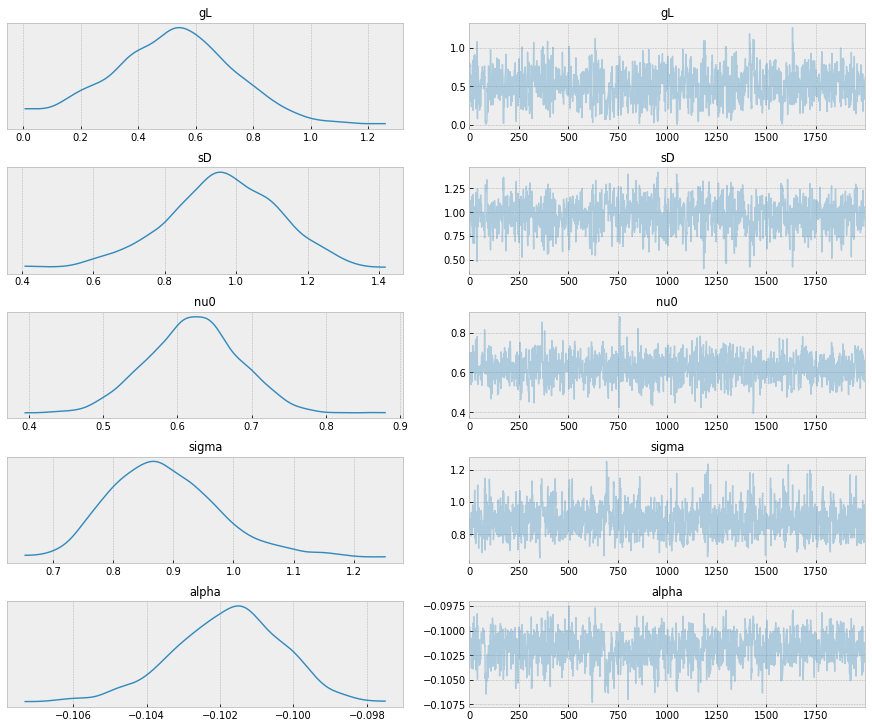

In [185]:
import arviz
arviz.plot_trace(mcmc, var_names=["gL", "sD","nu0","sigma","alpha"])
plt.show()

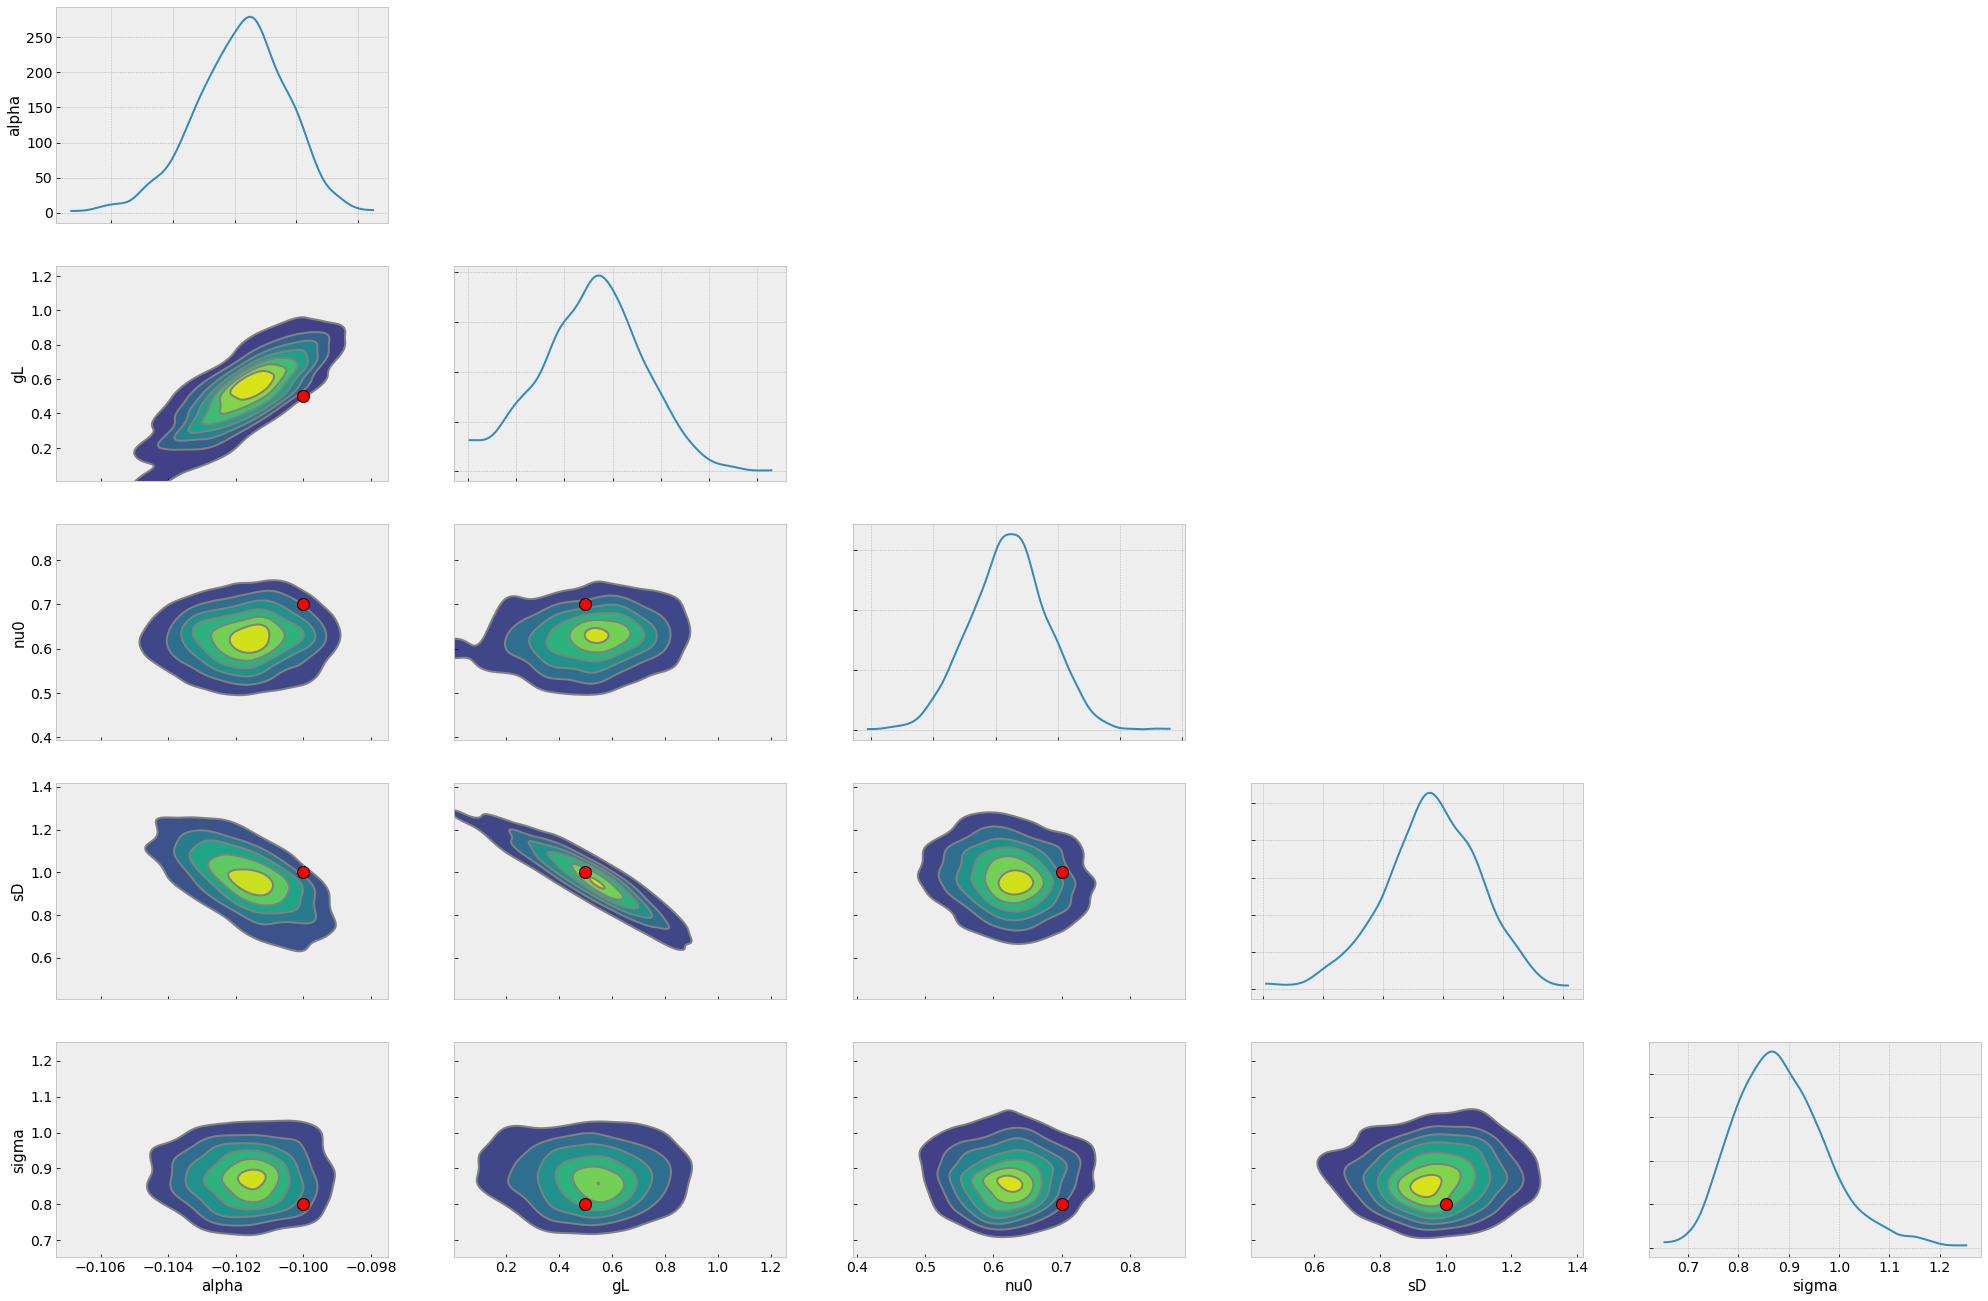

In [186]:
refs={}
#refs["A"]=Afix
refs["sD"]=1.0
refs["gL"]=0.5
refs["sigma"]=sigin
refs["nu0"]=0.7
refs["alpha"]=-0.1
arviz.plot_pair(arviz.from_numpyro(mcmc),kind='kde',divergences=False,\
                marginals=True,
                reference_values=refs,
               reference_values_kwargs={'color':"red", "marker":"o", "markersize":12}) 
plt.show()

In [165]:
# generating predictions
# hpdi is "highest posterior density interval"
posterior_sample = mcmc.get_samples()
pred = Predictive(model,posterior_sample)
nu_ = nuarr
predictions = pred(rng_key_,nu=nu_,y=None)
median_mu = jnp.median(predictions["y"],axis=0)
hpdi_mu = hpdi(predictions["y"], 0.9)

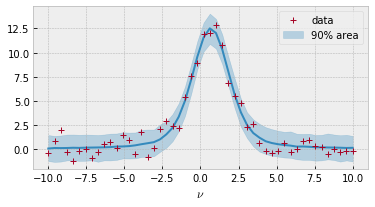

In [166]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 3))
ax.plot(nu_,median_mu,color="C0")
ax.plot(nuarr,data,"+",color="C1",label="data")
ax.fill_between(nu_, hpdi_mu[0], hpdi_mu[1], alpha=0.3, interpolate=True,color="C0",
                label="90% area")
plt.xlabel("$\\nu$")
plt.legend()
plt.savefig("../../documents/figures/mcmc_fitting_emission.png")
plt.show()

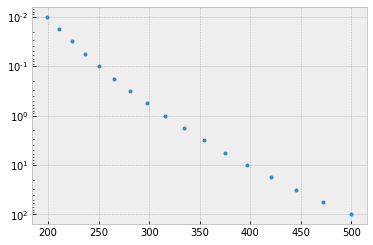

In [24]:
Tarr = 500.*(Parr/Parr[0])**0.1

plt.plot(Tarr,Parr,".")
#plt.xscale("log")
plt.yscale("log")
plt.gca().invert_yaxis()

In [11]:
def fdeltaI(carry,x):
    dtau,T=x
    source_function = Bplanck(T)
    y=beta_OK(dtau)*source_function + gamma_OK(dtau)*carry
    carry=source_function
    return carry, y

def alpha_OK(dtau):
    (jnp.exp(-dtau) - 1)/dtau 

def beta_OK(dtau):
    return 1 + alpha_OK(dtau)

def gamma_OK(dtau):
    return - jnp.exp(-dtau) - alpha_OK(dtau)

In [44]:
from jax import vmap


def g(x):
    """
    Params: 
      xs: free parameters
    """
    Tarr=x
    numic=0.5
    F0=jnp.ones(len(nuarr))*planck.nB(Tarr[0],numic)
    #F0=0.0
    init=[F0,Parr[0],0.7,1.0,0.5]
    FP,null=scan(add_layer,init,Tarr,NP)
    return FP[0]*3.e4

def g(x):
    Tarr=x
    numic=0.5
    F0=jnp.ones(len(nuarr))*planck.nB(Tarr[0],numic)  
    init=[F0,Parr[0],0.7,1.0,0.5]
    FP,null=scan(add_layer,init,Tarr,NP)
    return F0[0]

def df(x):
    ddf=vmap(grad(f))
    return ddf(x)


import jax.tools.jax_to_hlo
from jax.lib import xla_client

with open("g.txt", "w") as file:
    file.write(jax.tools.jax_to_hlo.jax_to_hlo(g,[ ("x" , xla_client.Shape("f32[17]")) ])[1])